# Assignment

In [1]:
# Import 

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
# ## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

# S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

# print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

# print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
# print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


# for i in range(5):
    
#     a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
#     a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

#     S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
#     ## PRINT CHESS BOARD AND VARIABLES
#     print('')
#     print(S)
#     print(R,'', Done)
#     print('check? ',env.check)
#     print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
#     # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
#     if Done:
#         break
        


In [4]:
# # PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

# S,X,allowed_a=env.Initialise_game()
# N_episodes=1000

# # VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
# R_save_random = np.zeros([N_episodes, 1])
# N_moves_save_random = np.zeros([N_episodes, 1])

# for n in range(N_episodes):
    
#     S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
#     Done=0                                  # SET Done=0 AT THE BEGINNING
#     i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
#     # UNTIL THE EPISODE IS NOT OVER...(Done=0)
#     while Done==0:
        
#         # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
#         a,_=np.where(allowed_a==1)
#         a_agent=np.random.permutation(a)[0]

#         S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
#         if Done:
            
#             R_save_random[n]=np.copy(R)
#             N_moves_save_random[n]=np.copy(i)

#             break

#         i=i+1                               # UPDATE THE COUNTER



# # AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# # (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

# print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))

In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK... (Xavier initialisation)
W1 = np.random.randn(N_h, N_in) * np.sqrt(1 / (N_in))
W2 = np.random.randn(N_a, N_h) * np.sqrt(1 / (N_h))

bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.00035       # THE LEARNING RATE

N_episodes = 20000 # THE NUMBER OF GAMES TO BE PLAYED

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
AVG_R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])
AVG_N_moves_save = np.zeros([N_episodes, 1])


In [6]:
class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

beta1=0.9 # First order momentum for Adam

# Intialise Adam for the parameters
Adam_W1=Adam(W1,beta1)
Adam_W2=Adam(W2,beta1)

Adam_bias_W1=Adam(bias_W1,beta1)
Adam_bias_W2=Adam(bias_W2,beta1)

In [7]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    # print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING

    accumulated_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        a, _ = np.where(allowed_a==1) # list of allowed action indicies
        # a_agent=np.random.permutation(a)[0]

        # https://www.v7labs.com/blog/neural-networks-activation-functions#:~:text=ReLU%20activation%20function%20should%20only,(due%20to%20vanishing%20gradients).
        # RELU activation should only be used in hidden layers
        h1 = np.dot(W1,X)+bias_W1       # Neural activation: input layer -> hidden layer
        x1 = h1*(h1>0)                  # Apply the RELU function
        h2 = np.dot(W2,x1)+bias_W2      # Neural activation: hidden layer -> output layer
        x2_Qvalues = 1/(1+np.exp(-h2))  # Apply the sigmoid function

        # Epsilon-greedy parameter
        # with probability epsilon choose action at random; if epsilon = 0 then always choose Greedy
        eGreedy = int(np.random.rand() < epsilon_f) 

        # Implement the policy
        if eGreedy:
            # if Qvalues are the same or epsilon>0 (e-Greedy) choose action at random
            a_agent = np.random.permutation(a)[0]
        else:
            # otherwise choose greedy. Will result in the action index which gives highest Q-value out of the possible actions
            a_agent = a[np.argmax(x2_Qvalues[a])]
            
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

        accumulated_reward += R

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            e_n = R - x2_Qvalues[a_agent]
            
            # Backpropagation: output layer -> hidden layer
            delta2 = x2_Qvalues*(1-x2_Qvalues) * e_n
            # delta2 = x2_Qvalues*np.heaviside(h2, 0.5) * e_n
            
            masked_delta2 = np.zeros_like(delta2)
            masked_delta2[a_agent] = delta2[a_agent]
            dW2 = np.outer(masked_delta2, x1)

            # Backpropagation: hidden layer -> input layer
            # delta1 = x1*np.heaviside(h1, 0.5) * np.dot(W2.T, masked_delta2)
            delta1 = x1*(1-x1) * np.dot(W2.T, masked_delta2)
            dW1 = np.outer(delta1, X)
            
            W2[a_agent] += eta*Adam_W2.Compute(dW2)[a_agent]
            bias_W2[a_agent] += eta*Adam_bias_W2.Compute(masked_delta2)[a_agent]
            W1 += eta*Adam_W1.Compute(dW1)
            bias_W1 += eta*Adam_bias_W1.Compute(delta1)

            R_save[n]=np.copy(accumulated_reward)
            AVG_R_save[n] = np.sum(R_save)/(n+1)
            N_moves_save[n]=np.copy(i)
            AVG_N_moves_save[n] = np.sum(N_moves_save)/(n+1)

            print('Episode',n,'finished. Average reward:',AVG_R_save[n][0],'Number of steps:',AVG_N_moves_save[n][0], end='\r')
            
            break
        
        # IF THE EPISODE IS NOT OVER...
        else:
            a2, _ = np.where(allowed_a_next==1)

            # SARSA target policy same as behaviour policy - epsilon greedy
            eGreedy = int(np.random.rand() < epsilon_f)
            if eGreedy:
                a_agent2 = np.random.permutation(a2)[0]
            else:
                a_agent2 = a2[np.argmax(x2_Qvalues[a2])]

            # Compute the error signal
            # target/desired output - actual output
            e_n = (R + gamma * x2_Qvalues[a_agent2]) - x2_Qvalues[a_agent]
            
            # Backpropagation: output layer -> hidden layer
            delta2 = x2_Qvalues*(1-x2_Qvalues) * e_n
            # delta2 = x2_Qvalues*np.heaviside(h2, 0.5) * e_n
            
            masked_delta2 = np.zeros_like(delta2)
            masked_delta2[a_agent] = delta2[a_agent]
            dW2 = np.outer(masked_delta2, x1)

            # Backpropagation: hidden layer -> input layer
            # delta1 = x1*np.heaviside(h1, 0.5) * np.dot(W2.T, masked_delta2)
            delta1 = x1*(1-x1) * np.dot(W2.T, masked_delta2)
            dW1 = np.outer(delta1, X)
            
            W2[a_agent] += eta*Adam_W2.Compute(dW2)[a_agent]
            bias_W2[a_agent] += eta*Adam_bias_W2.Compute(masked_delta2)[a_agent]
            W1 += eta*Adam_W1.Compute(dW1)
            bias_W1 += eta*Adam_bias_W1.Compute(delta1)
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('Random_Agent, Average reward:',AVG_R_save[-1][0],'Number of steps:',AVG_N_moves_save[-1][0])

# eta = 0.0001, draw=0

# worse using heaviside function - implemented correctly
# using a smaller penalty for moving (move=-0.01), allows the agent accumulate more reward

# eta = 0.00035, 20000 episodes
# 0.88, 7.2(base)
# 0.81, 6.8 (move=-0.01)
# 0.78, 8.7 (move=-0.01, draw=-0.05)

Random_Agent, Average reward: 0.8572 Number of steps: 9.4661ps: 9.4661teps: 9.466523326166309


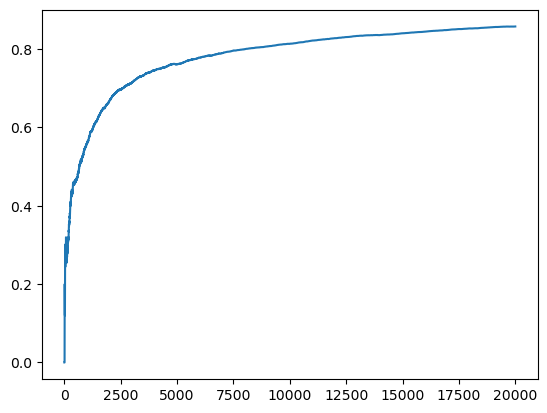

In [8]:
plt.plot(np.arange(0, N_episodes),AVG_R_save)